# K-Means Clustering: Principles and Custom Implementation
In this notebook, we will demostrate step-by-step, how _K-Means Clustering_ algorithm works.
For that purpose, we will use _scikit-learn_ library to generare a simple artificial dataset.
Our custom solution will be compared with _scikit-learn_ at the end of the notebook.

In [1]:
%pylab inline
from sklearn import datasets
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

import numpy as np
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


## The dataset
Although the math stays the same, the clustering algorithm may become less intuitive when the feature space is multidimensional.
For this reason, we will generate a 2-dimensional dataset with normally distributied data around three random points thus forming our _clusters_.
All of our clusters will contain the exact same standard deviation, so consequently we are contructing of a dataset that is a perfect case for a KMC algorithm, and it will be easier to explain.

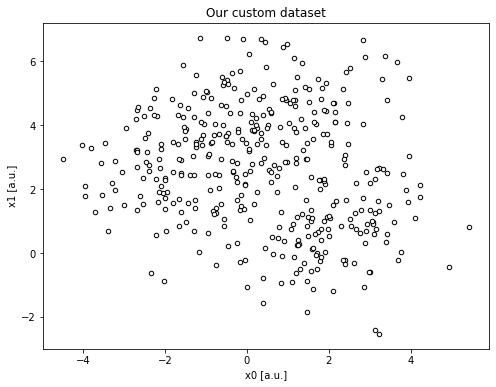

In [2]:
N_FEATURES = 2
K_CLUSTERS = 3

data, targets = make_blobs(
    n_samples=400,
    n_features=N_FEATURES,
    centers=K_CLUSTERS,
    cluster_std=1.25,
    shuffle=True,
    random_state=0)

fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(data[:, 0], data[:, 1],
    c='white', marker='o', edgecolor='black', s=20)
ax.set_xlabel('x0 [a.u.]')
ax.set_ylabel('x1 [a.u.]')
ax.set_title('Our custom dataset')
plt.show()

Here, we are deliberately ingnoring the `target`s, as our problem categorizes itself as **unsupervised learning**, and us such these will present the information that is unknown to us.

## The algorithm explained
### Distance
First of all, the KMC algorithm (just like _K-Nearest Neighbours_) needs some way of evaluating the points' similarity.
For that it requires a definition of _distance_, which we can implement using Minkowki definition, which if $p=2$ becomes the standard Euclidean distance.

$$\text{d}(x, y) = \left(\sum_{n = 0}^{N-1} |x_n - y_n|^p \right)^{1/p}$$, where
$N$ is a number of features.

In [3]:
def distance(x, y, p=2):
    return ((abs(x - y)**p).sum())**(1/p)

assert distance(np.array([0, 0]), np.array([0, 0])) == 0
assert distance(np.array([1, 0]), np.array([1, 0])) == 0
assert distance(np.array([1, 0]), np.array([0, 0])) == 1
assert distance(np.array([1, 0]), np.array([0, 1])) == np.sqrt(2)

### Input formatting
Before we begin, let's encapsulate our dataset in _pandas_ object.
Although [not as fast as numpy](https://zerowithdot.com/data-science-computation-harakiri/), it simplifies the analytics by giving us access to more methods.

In [4]:
FEATURES = ['x' + str(x) for x in range(N_FEATURES)]
X = pd.DataFrame(data, columns=FEATURES)
X.head()

,x0,x1
0,-2.219791,2.329585
1,-1.990284,1.735863
2,2.400521,2.760255
3,1.509093,5.149922
4,-0.509804,3.670267


### Custom implementation

In [5]:
def km_clustering(X, K, max_iter=10, eps=1e-3):
    Z = X.copy()
    MAX_ITER = max_iter
    EPSILON = eps
    DISTANCES = ['d(x, c{})'.format(k) for k in range(K)]

    # step 1. initialization
    np.random.seed(1)
    idx = np.random.randint(0, Z.shape[0], K)
    centroids = X.iloc[idx, :].copy()
    centroids = centroids.reset_index(drop='Index')

    history = np.zeros((MAX_ITER, K, N_FEATURES))
    history[0, :, :] = centroids

    # step 4. repeat 2. and 3. until no more change
    for i in range(1, MAX_ITER):
        # step 2. evaluating minimum distance
        for k in range(K):
            centroid = centroids.iloc[k].to_numpy()
            Z[DISTANCES[k]] = X.apply(lambda x: distance(x, centroid), axis=1)
        belongs_to = 'cluster (i={})'.format(i)
        Z[belongs_to] = Z[DISTANCES].idxmin(axis=1)
        Z[belongs_to] = Z[belongs_to].apply(lambda x: np.argwhere(np.array(DISTANCES) == x)[0][0])

        # step 3. calculating new centroids (shifting)
        for k in range(K):
            centroids.iloc[k] = Z[Z[belongs_to] == k][FEATURES].mean()
        history[i, :, :] = centroids
        if (abs(history[i-1] - centroids).max().max() < EPSILON):
            break
    
    return history, Z[FEATURES + [c for c in Z.columns if c.startswith('cluster')]]

Our function `km_clustering` will accept four inputs:
* The dataset `X`, which it will create a copy of to ensure we do not alter the initial dataset,
* The number of declared clusters `K`,
* `max_iter` to terminate the procedure after this value is reached,
* `eps` to be our max tolernce for the so-called _intertia_, also used to terminate the algorithm.

**Step 1.** is the _initialization_.
Here, line #8 is optionally added to ensure the repeatability of the random number generator.
Line #9 picks `K` random integers within the range of our example number.
Line #10 then creates a small dataframe to hold our _centroid_'s coordinates, whose values are initalized using the randomly selected points.
Then line #11 resets the index of the `centroids` to enumerate the coordinates' vectors.

Becasue we would like to demonstrate here of how the algorithm progresses, we will create a snapshot of the `centroids` object-array at any given iteration.
We also preinitialize the `history` @0th iteration to the already selected centroids (line #14).

**Step 2.** starts with the inner loop over the intended number of clusters `K`.
For every centroid `k` (line #20), we measure the distance between it and every example point in our dataset (line #21), and save the result alongside our dataset copy `Z`.
Then (#22-23), we pick the distance that was of the minimum value and look for index of the cluster to associate the point with (#24).
This way, every data point has been given an additional index representing the cluster it is now a part of.

**Step 3.** is evaluating new centroids' coordinates.
After new clusters have been formed, the cetroids can be defined by taking the average of each points' coordinates.
At this moment, we can also take a new snapshot (#29) and evaluate if the change of the position of the centroids with respect to the last one has changed beyond our targeted tolerance (#30). If not, our procedure is finished.

**Step 4.** is consecutively repeating steps 2. and 3. until either the maximum number of iteration is reached, or the changes to the centroids' positions becomes so small that is makes no sense to continue.

Finally, the function returns both the appended dataset and the history of the centroids' positions.

### Visualizing progression
Now, let's execute our `km_clustering` function and demonstrate how it operaties.
Note that we ask it to formulate three clusters, while we _know_ our dataset has three. This is a highly artificial situation. 

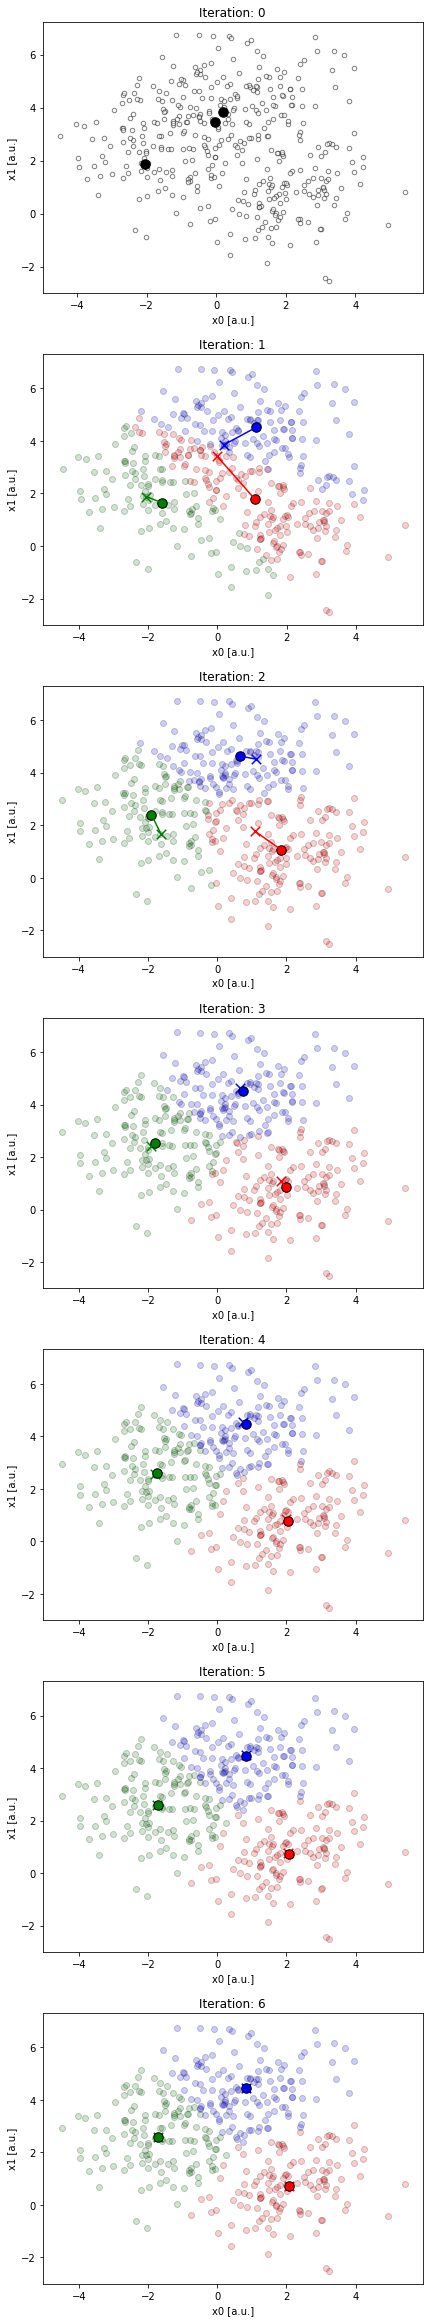

In [6]:
import itertools

K = 3
h, Z = km_clustering(X, K)
ITERS = len([c for c in Z.columns if c.startswith('cluster')]) + 1

fig, axs = plt.subplots(ITERS, 1, figsize=(6, 32))
plt.tight_layout(w_pad=4, h_pad=4)

axs[0].scatter(data[:, 0], data[:, 1],
    c='white', marker='o', edgecolor='black', s=20, alpha=0.5)
for k in range(K):
    axs[0].scatter(h[0, k, 0], h[0, k, 1], c='k', marker='o', edgecolor='k', s=90)
    axs[0].set_xlabel('x0 [a.u.]')
    axs[0].set_ylabel('x1 [a.u.]')
    axs[0].set_title('Iteration: 0')

for i in range(1, ITERS):
    colors = itertools.cycle(['r', 'g', 'b', 'm', 'c', 'y'])
    for k in range(K):
        c = next(colors)
        z = Z[Z['cluster (i={})'.format(i)] == k][FEATURES].to_numpy()
    
        axs[i].scatter(z[:, 0], z[:, 1], c=c, marker='o', edgecolor='k', alpha=0.2)
        axs[i].scatter(h[i-1, k, 0], h[i-1, k, 1], c=c, marker='x', edgecolor='k', s=90)
        axs[i].scatter(h[i, k, 0], h[i, k, 1], c=c, marker='o', edgecolor='k', s=90)
        axs[i].plot([h[i-1, k, 0], h[i, k, 0]], [h[i-1, k, 1], h[i, k, 1]], c=c)
        axs[i].set_xlabel('x0 [a.u.]')
        axs[i].set_ylabel('x1 [a.u.]')
        axs[i].set_title('Iteration: {}'.format(i))
plt.show()

Looking at the figures above, we can observe that the centroids move less and less with every new iteration. Above the 6th iteration, the shift is so tiny that it makes sense to stop the computation.

## Scikit-Learn implementation
Now, let's compare our result with implementation offered with _scikit-learn_ library.

For easiness, we will keep the same dataset and use the declared number of cluster `K = 3`.

In [7]:
K = 3
y_pred = KMeans(n_clusters=K, random_state=0).fit_predict(X)
X1 = X.copy()
X1['cluster'] = y_pred

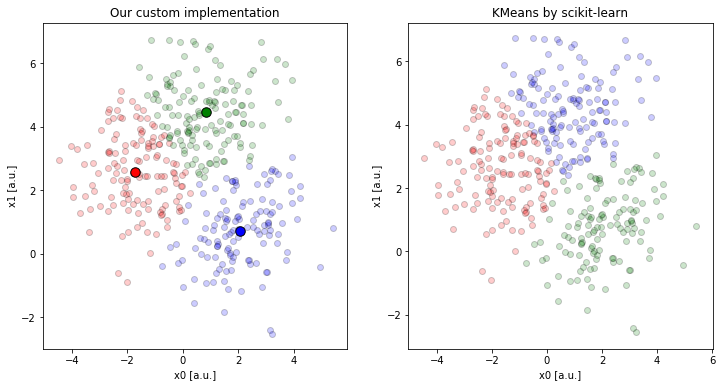

In [8]:
h, Z = km_clustering(X, K)
ITERS = len([c for c in Z.columns if c.startswith('cluster')])

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

colors = itertools.cycle(['r', 'g', 'b', 'm', 'c', 'y'])
for k in range(K):
    z = Z[Z['cluster (i={})'.format(ITERS)] == k][FEATURES].to_numpy()

    axs[0].scatter(z[:, 0], z[:, 1], c=c, marker='o', edgecolor='k', alpha=0.2)
    axs[0].scatter(h[ITERS, k, 0], h[ITERS, k, 1], c=c, marker='o', edgecolor='k', s=90)
    axs[0].set_xlabel('x0 [a.u.]')
    axs[0].set_ylabel('x1 [a.u.]')
    axs[0].set_title('Our custom implementation')
    c = next(colors)

colors = itertools.cycle(['r', 'g', 'b', 'm', 'c', 'y'])
for k in range(K):
    x = X1[X1['cluster'] == k][FEATURES].to_numpy()

    axs[1].scatter(x[:, 0], x[:, 1], c=c, marker='o', edgecolor='k', alpha=0.2)
    axs[1].set_xlabel('x0 [a.u.]')
    axs[1].set_ylabel('x1 [a.u.]')
    axs[1].set_title('KMeans by scikit-learn')
    c = next(colors)

plt.show()

Despite the clusters are differently labelled, they encompase the same subsets of data.

## Conclusions
In this notebook we demonstrated the implementation of the _K-Means Clustering_ algorithm "under the hood", and compared it against the one offered with _scikit-learn_ on a custom, artificial dataset that we generated.

Despite the _KMC_ algorithm is often a popular choice, it does not guaranee the performance on skewed datasets of e.g. unequal standard deviations or dataset that ar not Gaussian at all.
Also, since we knew the number of clusters we expected the dataset to have, we had an unfair advantage.
We will look at that problem in the next notebook.